# The Battle of the Neighborhoods
### Applied Data Science Capstone Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This notebook will try to find similar neighborhoods in two different cities based on the type of venues and popular spots contained in the neighborhoods. Specifically, we will look at neighborhoods in two major cities; (Manhattan) New York, New York USA and Toronto, Ontario Canada.

This project would be of interest to people moving between the two cities who are looking to settle in similar areas. This project would also be of interest to companies looking to move headquarters or open up branch offices in areas that are similar to the ones they currently operate in.

## Data <a name="data"></a>

In order to complete our project we will need the following data:

* Coordinate Data for the city centers of Manhattan and Toronto, available from **GeoPy Nominatim**
* Coordinate Data for the neighborhoods in Manhattan, available at this URL: **https://cocl.us/new_york_dataset**
* Neighborhoods in Toronto by postal code, available on **Wikipedia: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M**
* Coordinate Data for postal codes in Toronto, available at this URL: **http://cocl.us/Geospatial_data**
* Coordinate Data and Venue/spot type from **Foursquare API**

Using this data we will classify the various neighborhoods of Manhattan into categories based on the most common types of venues.
Then, will see if we can find neighborhoods of Toronto Proper that can be placed into those same categories.

### Libraries
Let's start by importing all the various libraries necessary to complete our project.

In [2]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

import folium
!conda install lxml -y

from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge

The following packages will be UPDATED:

    certifi: 2019.9.11-py36_0  --> 2019.9.11-py36_0  conda-forge

The following packages will be DOWNGRADED:

    openssl: 1.1.1d-h7b6447c_1 --> 1.1.1c-h516909a_0 conda-forge


certifi-2019.9.11    | 147 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of cond

### Manhattan Data
In the following code will download the Manhattan neighborhood data and save this into a Pandas dataframe.
Then we will use **Nominatim** and **Folium** to generate a map of Manhattan with the neighborhoods' locations marked.
Finally, we will make calls to the **Foursquare API** to generate a table containing venue data.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc = nyc.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
nyc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
manhattan = nyc[nyc['Borough'] == 'Manhattan'].reset_index(drop = True)

In [9]:
manhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [10]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Manhattan are 40.7896239, -73.9598939.


In [248]:
# create map of NYC using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan['Latitude'], manhattan['Longitude'], manhattan['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

In [12]:
CLIENT_ID = 'LPZSFB43ERMD5CGNEPJB1Q2RWAU2AH252LE2FQJJDMOIH3SO' # your Foursquare ID
CLIENT_SECRET = 'R4B0KM1XF34MTFRBDPBH5ARFBM1GNFTWNNZN21UOLCIN0K4Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LPZSFB43ERMD5CGNEPJB1Q2RWAU2AH252LE2FQJJDMOIH3SO
CLIENT_SECRET:R4B0KM1XF34MTFRBDPBH5ARFBM1GNFTWNNZN21UOLCIN0K4Y


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
manhattan_venues = getNearbyVenues(names=manhattan['Neighborhood'],
                                   latitudes=manhattan['Latitude'],
                                   longitudes=manhattan['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [15]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [16]:
print('There are {} unique categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 337 unique categories.


### Toronto Data
In the following code will download the Toronto neighborhood data from **Wikipedia** and save this into a Pandas dataframe along with coordinate data from this URL **http://cocl.us/Geospatial_data**.
Then we will use **Nominatim** and **Folium** to generate a map of Toronto with the neighborhoods' locations marked.
Finally, we will make calls to the **Foursquare API** to generate a table containing venue data.

In [17]:
# read the table off the webpage
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(link)

In [18]:
# first item in the list is the table needed
type(tables)
df = tables[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [19]:
# drop entries with an unassigned borough
df = df[df['Borough']!= 'Not assigned'].reset_index(drop = True)

In [20]:
# assign borough name to neighborhood name for single entry
df[df['Neighbourhood'] == 'Not assigned']
df.iloc[6][2] = df.iloc[6][1]

In [21]:
# clean up column names
df.rename(columns = {'Postcode':'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace = True)
df.sort_values('PostalCode', inplace = True, ascending = True)
df = df.reset_index(drop = True)

In [22]:
toronto = df[df['Borough'].str.contains("Toronto")].reset_index(drop = True)

In [23]:
# grouping by postcode and borough put neighborhoods together
toronto = toronto.groupby(['PostalCode','Borough'], as_index = False, sort = False).agg(", ".join)

In [24]:
# download coordinates
!wget -q -O 'latlon.csv' http://cocl.us/Geospatial_data

latlon_df = pd.read_csv('latlon.csv')

latlon_df.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

# merge dataframes to obtain final dataframe
toronto = pd.merge(toronto, latlon_df, how = 'inner', on = 'PostalCode')


In [25]:
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [26]:
# use geolocator to get coordinates for Toronto
t_address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
t_location = geolocator.geocode(t_address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude
print('The geograpical coordinates of Toronto, ON are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinates of Toronto, ON are 43.655115, -79.380219.


In [249]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}; {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [28]:
toronto_venues = getNearbyVenues(names = toronto['Neighborhood'],
                                   latitudes = toronto['Latitude'],
                                   longitudes = toronto['Longitude']
                                  )


The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
South Hill, Rathnelly, Summerhill West, Deer Park, Forest Hill SE
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Regent Park, Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
King, Adelaide, Richmond
Toronto Islands, Harbourfront East, Union Station
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, Yorkville, North Midtown
University of Toronto, Harbord
Kensington Market, Grange Park, Chinatown
Railway Lands, South Niagara, Harbourfront West, Island airport, Bathurst Quay, CN Tower, King and Spadina
Stn A PO Boxes 25 The Esplanade
Underground city, First Canadian Place
Christie
Dovercourt Village, Dufferin
Trinity, Little Portugal
Exhibition Place, Brockton, Parkdale Village
High Park, The 

In [29]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [39]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 240 unique categories.


## Methodology <a name="methodology"></a>

Now that we have our dataframes containing venue data from each city let's use one hot encoding to count the number of each venue type. However, we can see that there are more unique venue categories in Manhattan than in Toronto so we will have to drop any categories not shared by both cities.

In [197]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [198]:
manhattan_onehot = manhattan_onehot[manhattan_onehot.columns&toronto_onehot.columns]

In [199]:
toronto_onehot = toronto_onehot[manhattan_onehot.columns&toronto_onehot.columns]

In [200]:
# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Marbl

In [50]:
manhattan_onehot.shape

(3331, 195)

In [201]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Battery Park City,0.00,0.010000,0.00,0.000000,0.00,0.000000,0.000000,0.01,0.000000,0.020000,0.00,0.000000,0.010000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.010000,0.00,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.0100,0.020000,0.01,0.000000,0.000000,0.00,0.000000,0.00,0.0000,0.000000,0.00,0.010000,0.00,0.000000,0.020000,0.000000,0.070000,0.0000,0.000000,0.010000,0.00,0.00,0.000000,0.02,0.000000,0.000000,0.010000,0.010000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.01,0.0100,0.000000,0.020000,0.040000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.050000,0.0000,0.00,0.020000,0.000000,0.00,0.00,0.030000,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.01,0.000000,0.010000,0.00,0.000000,0.00,0.00,0.01,0.01,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.00,0.090000,0.010000,0.00,0.010000,0.000000,0.020000,0.020000,0.020000,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0000

In [202]:
toronto_onehot.head()

,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [203]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The B

In [204]:
# calculate mean number of each type of venue
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.0000,0.000000,0.017544,0.0000,0.017544,0.035088,0.000000,0.000000,0.00,0.035088,0.000000,0.000000,0.017544,0.00,0.0000,0.000000,0.00000,0.000000,0.017544,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.00,0.000000,0.035088,0.000000,0.000000,0.000000,0.017544,0.052632,0.070175,0.017544,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.017544,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.00,0.00,0.000000,0.000000,0.000000,0.017544,0.035088,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.000000,0.000000,0.017544,0.000000,0.000000,0.00,0.000000,0.00,0.017544,0.000000,0.00000

Now let's take a look at the 10 most common venue types in each neighborhood.

In [55]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [207]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Italian Restaurant,Burger Joint,Ice Cream Shop,Shopping Mall,Boat or Ferry,Plaza
1,Carnegie Hill,Coffee Shop,Pizza Place,Cosmetics Shop,Café,Spa,Bar,Bakery,Bookstore,Japanese Restaurant,Yoga Studio
2,Central Harlem,Chinese Restaurant,Gym / Fitness Center,Seafood Restaurant,Bar,French Restaurant,American Restaurant,Cosmetics Shop,Metro Station,Bookstore,Boutique
3,Chelsea,Coffee Shop,Ice Cream Shop,Bakery,Italian Restaurant,Nightclub,American Restaurant,Theater,Hotel,Seafood Restaurant,Art Gallery
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bubble Tea Shop,Optical Shop,Spa,Korean Restaurant


In [205]:
# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Café,Italian Restaurant,Cheese Shop,Farmers Market,Beer Bar,Steakhouse
1,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Garden Center,Skate Park,Smoke Shop,Fast Food Restaurant,Park,Burrito Place,Spa,Butcher,Restaurant
2,"Cabbagetown, St. James Town",Coffee Shop,Café,Bakery,Pizza Place,Pub,Italian Restaurant,Restaurant,Grocery Store,Snack Place,Jewelry Store
3,Central Bay Street,Coffee Shop,Middle Eastern Restaurant,Café,Italian Restaurant,Burger Joint,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Japanese Restaurant
4,Christie,Café,Grocery Store,Park,Coffee Shop,Restaurant,Nightclub,Baby Store,Diner,Italian Restaurant,Athletics & Sports


Next let's cluster the neighborhoods in Manhattan, but first we will use the elbow method to determine the best k for the KMeans algorithm (if any).

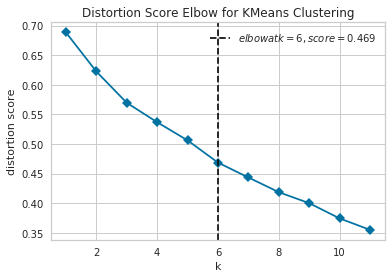

In [67]:
# determine best k using elbow method
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)


model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,12), metric='distortion', timings=False, locate_elbow=True
)

visualizer.fit(manhattan_grouped_clustering)        
visualizer.poof()        

Unfortunately, our analysis doesn't give us a conclusive elbow point so let's go with 6 as our k.

In [68]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 1, 1, 1, 4, 4, 0, 1, 4], dtype=int32)

In [208]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [208]:
manhattan_merged = manhattan

# merge manhattan_grouped with manhattan to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Coffee Shop,Sandwich Place,Yoga Studio,Steakhouse,Gym,Ice Cream Shop,Miscellaneous Shop,Donut Shop,Discount Store,Diner
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bubble Tea Shop,Optical Shop,Spa,Korean Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Deli / Bodega,Grocery Store,Sandwich Place,Tapas Restaurant,Pizza Place,Park,Chinese Restaurant,Coffee Shop
3,Manhattan,Inwood,40.867684,-73.921210,0,Café,Mexican Restaurant,Pizza Place,Lounge,Deli / Bodega,Wine Bar,American Restaurant,Chinese Restaurant,Park,Bakery
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Pizza Place,Café,Coffee Shop,Yoga Studio,Bank,Park,Cocktail Bar,Chinese Restaurant,Caribbean Restaurant


Now, let's put our clusters on a map of Manhattan and then look at each individual cluster to analyze them.

In [209]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Cluster 0** appears to be dominated by cafes and Mexican restaurants. 

In [210]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,0,Café,Bakery,Deli / Bodega,Grocery Store,Sandwich Place,Tapas Restaurant,Pizza Place,Park,Chinese Restaurant,Coffee Shop
3,Inwood,0,Café,Mexican Restaurant,Pizza Place,Lounge,Deli / Bodega,Wine Bar,American Restaurant,Chinese Restaurant,Park,Bakery
4,Hamilton Heights,0,Mexican Restaurant,Pizza Place,Café,Coffee Shop,Yoga Studio,Bank,Park,Cocktail Bar,Chinese Restaurant,Caribbean Restaurant
5,Manhattanville,0,Coffee Shop,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Deli / Bodega,Liquor Store,Park,Chinese Restaurant,Ramen Restaurant,Juice Bar
7,East Harlem,0,Mexican Restaurant,Deli / Bodega,Bakery,Pizza Place,Latin American Restaurant,Thai Restaurant,Performing Arts Venue,Coffee Shop,Café,Restaurant
25,Manhattan Valley,0,Coffee Shop,Pizza Place,Indian Restaurant,Thai Restaurant,Spa,Bar,Mexican Restaurant,Deli / Bodega,Yoga Studio,French Restaurant
36,Tudor City,0,Café,Park,Mexican Restaurant,Sushi Restaurant,Greek Restaurant,Pizza Place,Deli / Bodega,Dog Run,Burger Joint,Restaurant


**Cluster 1** appears to be dominated by Chinese and Italian restaurants and fitness centers/spas

In [211]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,1,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bubble Tea Shop,Optical Shop,Spa,Korean Restaurant
6,Central Harlem,1,Chinese Restaurant,Gym / Fitness Center,Seafood Restaurant,Bar,French Restaurant,American Restaurant,Cosmetics Shop,Metro Station,Bookstore,Boutique
8,Upper East Side,1,Italian Restaurant,Art Gallery,Bakery,Coffee Shop,Juice Bar,Gym / Fitness Center,Hotel,French Restaurant,Spa,Pizza Place
9,Yorkville,1,Gym,Italian Restaurant,Bar,Coffee Shop,Pizza Place,Deli / Bodega,Sushi Restaurant,Diner,Mexican Restaurant,Japanese Restaurant
10,Lenox Hill,1,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Sporting Goods Shop,Gym / Fitness Center,Gym,Burger Joint,Café,Cosmetics Shop
12,Upper West Side,1,Italian Restaurant,Wine Bar,Coffee Shop,Bar,Indian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Cosmetics Shop,Pet Store,Ice Cream Shop
17,Chelsea,1,Coffee Shop,Ice Cream Shop,Bakery,Italian Restaurant,Nightclub,American Restaurant,Theater,Hotel,Seafood Restaurant,Art Gallery
18,Greenwich Village,1,Italian Restaurant,Clothing Store,Sushi Restaurant,French Restaurant,Indian Restaurant,Seafood Restaurant,Cosmetics Shop,Café,Chinese Restaurant,Gym
19,East Village,1,Bar,Wine Bar,Ice Cream Shop,Pizza Place,Chinese Restaurant,Mexican Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Korean Restaurant
20,Lower East Side,1,Coffee Shop,Café,Pizza Place,Sandwich Place,Art Gallery,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Cocktail Bar,Bakery


**CLuster 2** seems to be dominated by Korean restaurants and hotels.

In [212]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,2,Korean Restaurant,Hotel,Hotel Bar,Cosmetics Shop,Japanese Restaurant,Dessert Shop,Gym / Fitness Center,American Restaurant,Coffee Shop,Yoga Studio


**Cluster 3** seems to be dominated by parks.

In [74]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,3,Park,Coffee Shop,Sandwich Place,Metro Station,Bubble Tea Shop,Scenic Lookout,Liquor Store,Supermarket,Bus Line,Plaza


**Cluster 4** seems to have a lot of gyms but also a significant number of cultural venues like theaters and concert halls.

In [213]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,4,Coffee Shop,Sandwich Place,Yoga Studio,Steakhouse,Gym,Ice Cream Shop,Miscellaneous Shop,Donut Shop,Discount Store,Diner
13,Lincoln Square,4,Gym / Fitness Center,Theater,Café,Italian Restaurant,Plaza,Concert Hall,French Restaurant,Opera House,Park,Indie Movie Theater
14,Clinton,4,Theater,Gym / Fitness Center,American Restaurant,Spa,Italian Restaurant,Hotel,Sandwich Place,Gym,Lounge,Coffee Shop
15,Midtown,4,Hotel,Clothing Store,Cocktail Bar,Coffee Shop,Theater,Japanese Restaurant,Steakhouse,Café,Bookstore,Bakery
16,Murray Hill,4,Coffee Shop,Sandwich Place,Hotel,Japanese Restaurant,French Restaurant,American Restaurant,Gym,Gym / Fitness Center,Italian Restaurant,Bagel Shop
23,Soho,4,Clothing Store,Boutique,Shoe Store,Art Gallery,Mediterranean Restaurant,Spa,Bakery,Men's Store,Italian Restaurant,Furniture / Home Store
26,Morningside Heights,4,Bookstore,American Restaurant,Park,Coffee Shop,Sandwich Place,Deli / Bodega,Burger Joint,Food Truck,Tennis Court,Juice Bar
28,Battery Park City,4,Park,Coffee Shop,Hotel,Gym,Italian Restaurant,Burger Joint,Ice Cream Shop,Shopping Mall,Boat or Ferry,Plaza
29,Financial District,4,Coffee Shop,Hotel,Pizza Place,Gym,Event Space,American Restaurant,Food Truck,Cocktail Bar,Gym / Fitness Center,Steakhouse
32,Civic Center,4,Gym / Fitness Center,Coffee Shop,French Restaurant,Hotel,Italian Restaurant,Sandwich Place,Sporting Goods Shop,Park,Cocktail Bar,Spa


**Cluster 5** seems to have a lot of Ferry ports.

In [76]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,5,Boat or Ferry,Park,Bar,Playground,Fountain,Harbor / Marina,Farmers Market,Bistro,Coffee Shop,Cocktail Bar


Next, let's cluster the Toronto neighborhoods, however this will be done to find our best k when running the k-Nearest Neighbors algorithm.

In [214]:
# set number of clusters
t_kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
t_kmeans = KMeans(n_clusters=t_kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
t_kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 5, 0, 0, 0, 0, 1,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [215]:
X = manhattan_grouped_clustering.values
X.shape

(40, 194)

In [216]:
y = manhattan_merged["Cluster Labels"].values
y.shape

(40,)

In [217]:
Z = toronto_grouped_clustering.values
Z.shape

(38, 194)

In [218]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X,y)
    yhat=neigh.predict(Z)
    mean_acc[n-1] = metrics.accuracy_score(t_kmeans.labels_, yhat)

mean_acc

array([0.18421053, 0.26315789, 0.36842105, 0.10526316, 0.10526316,
       0.10526316, 0.07894737, 0.05263158, 0.07894737])

As we can see, our most accurate k for K-Nearest Neighbors appears to be k = 3.

In [219]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

Now, that we've trained our model on the Manhattan clusters let's use it to predict labels for neighborhood clusters in Toronto.

In [220]:
yhat = neigh.predict(Z)

In [221]:
yhat

array([0, 1, 1, 0, 2, 1, 4, 4, 4, 1, 0, 1, 3, 1, 0, 4, 4, 1, 0, 1, 0, 4,
       1, 4, 0, 1, 0, 0, 0, 1, 0, 4, 0, 4, 0, 1, 4, 1], dtype=int32)

In [222]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', yhat)

In [222]:
toronto_merged = toronto

# merge manhattan_grouped with manhattan to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Indian Restaurant,Grocery Store,Juice Bar,Liquor Store
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,4,Park,Pizza Place,Sandwich Place,Pet Store,Steakhouse,Ice Cream Shop,Italian Restaurant,Food & Drink Shop,Liquor Store,Fast Food Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Bar,Seafood Restaurant,Fish Market,Cheese Shop,Chinese Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


Now, let's map our Toronto clusters using the same colors as the Manhattan clusters.

In [223]:
# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results <a name="results"></a>

Now, let's examine the Toronto clusters to see how well they fit the Manhattan cluster definitions we stated earlier.
While, **Toronto cluster 0** does have quite a few cafes there isn't much we can say about the other clusters and they don't seem to fit the Manhattan cluster definitions very well. This shouldn't really come as a surprise as our highest accuracy through the k-Nearest Neighbors algorithm was only about **37%**.

In [225]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,0,Health Food Store,Trail,Pub,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Indian Restaurant,Grocery Store,Juice Bar,Liquor Store
3,Studio District,0,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Bar,Seafood Restaurant,Fish Market,Cheese Shop,Chinese Restaurant
14,"Ryerson, Garden District",0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Bookstore,Italian Restaurant,Ramen Restaurant,Plaza,Bubble Tea Shop
15,St. James Town,0,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Cocktail Bar,Bakery,Cosmetics Shop,Clothing Store,Breakfast Spot
16,Berczy Park,0,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Café,Italian Restaurant,Cheese Shop,Farmers Market,Beer Bar,Steakhouse
17,Central Bay Street,0,Coffee Shop,Middle Eastern Restaurant,Café,Italian Restaurant,Burger Joint,Sandwich Place,Ice Cream Shop,Sushi Restaurant,Chinese Restaurant,Japanese Restaurant
18,"King, Adelaide, Richmond",0,Coffee Shop,Café,Bar,Steakhouse,Cosmetics Shop,American Restaurant,Hotel,Burger Joint,Thai Restaurant,Restaurant
19,"Toronto Islands, Harbourfront East, Union Station",0,Coffee Shop,Hotel,Café,Fried Chicken Joint,Scenic Lookout,Sports Bar,Italian Restaurant,Pizza Place,Plaza,Restaurant
27,"Railway Lands, South Niagara, Harbourfront Wes...",0,Bar,Boutique,Harbor / Marina,Boat or Ferry,Coffee Shop,Sculpture Garden,Yoga Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market


In [226]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,0,Café,Bakery,Deli / Bodega,Grocery Store,Sandwich Place,Tapas Restaurant,Pizza Place,Park,Chinese Restaurant,Coffee Shop
3,Inwood,0,Café,Mexican Restaurant,Pizza Place,Lounge,Deli / Bodega,Wine Bar,American Restaurant,Chinese Restaurant,Park,Bakery
4,Hamilton Heights,0,Mexican Restaurant,Pizza Place,Café,Coffee Shop,Yoga Studio,Bank,Park,Cocktail Bar,Chinese Restaurant,Caribbean Restaurant
5,Manhattanville,0,Coffee Shop,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Deli / Bodega,Liquor Store,Park,Chinese Restaurant,Ramen Restaurant,Juice Bar
7,East Harlem,0,Mexican Restaurant,Deli / Bodega,Bakery,Pizza Place,Latin American Restaurant,Thai Restaurant,Performing Arts Venue,Coffee Shop,Café,Restaurant
25,Manhattan Valley,0,Coffee Shop,Pizza Place,Indian Restaurant,Thai Restaurant,Spa,Bar,Mexican Restaurant,Deli / Bodega,Yoga Studio,French Restaurant
36,Tudor City,0,Café,Park,Mexican Restaurant,Sushi Restaurant,Greek Restaurant,Pizza Place,Deli / Bodega,Dog Run,Burger Joint,Restaurant


In [227]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,North Toronto West,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Spa,Restaurant,Rental Car Location,Salon / Barbershop,Chinese Restaurant,Burger Joint,Diner
9,"South Hill, Rathnelly, Summerhill West, Deer P...",1,Pub,Coffee Shop,Sushi Restaurant,Pizza Place,Restaurant,Supermarket,Bagel Shop,Sports Bar,Fried Chicken Joint,Health & Beauty Service
11,"Cabbagetown, St. James Town",1,Coffee Shop,Café,Bakery,Pizza Place,Pub,Italian Restaurant,Restaurant,Grocery Store,Snack Place,Jewelry Store
12,Church and Wellesley,1,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Men's Store,Gastropub,Hotel,Fast Food Restaurant,Mediterranean Restaurant
13,"Regent Park, Harbourfront",1,Coffee Shop,Bakery,Park,Pub,Café,Breakfast Spot,Gym / Fitness Center,Mexican Restaurant,Theater,Restaurant
22,Roselawn,1,Health & Beauty Service,Ice Cream Shop,Garden,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
23,"Forest Hill North, Forest Hill West",1,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant
24,"The Annex, Yorkville, North Midtown",1,Sandwich Place,Café,Coffee Shop,Pizza Place,Pharmacy,Pub,Liquor Store,Indian Restaurant,Jewish Restaurant,BBQ Joint
25,"University of Toronto, Harbord",1,Café,Bookstore,Bakery,Japanese Restaurant,Restaurant,Bar,Sandwich Place,Beer Store,Italian Restaurant,French Restaurant
26,"Kensington Market, Grange Park, Chinatown",1,Café,Vegetarian / Vegan Restaurant,Bar,Mexican Restaurant,Bakery,Vietnamese Restaurant,Dumpling Restaurant,Chinese Restaurant,Coffee Shop,Dessert Shop


In [228]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,1,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Bubble Tea Shop,Optical Shop,Spa,Korean Restaurant
6,Central Harlem,1,Chinese Restaurant,Gym / Fitness Center,Seafood Restaurant,Bar,French Restaurant,American Restaurant,Cosmetics Shop,Metro Station,Bookstore,Boutique
8,Upper East Side,1,Italian Restaurant,Art Gallery,Bakery,Coffee Shop,Juice Bar,Gym / Fitness Center,Hotel,French Restaurant,Spa,Pizza Place
9,Yorkville,1,Gym,Italian Restaurant,Bar,Coffee Shop,Pizza Place,Deli / Bodega,Sushi Restaurant,Diner,Mexican Restaurant,Japanese Restaurant
10,Lenox Hill,1,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Sporting Goods Shop,Gym / Fitness Center,Gym,Burger Joint,Café,Cosmetics Shop
12,Upper West Side,1,Italian Restaurant,Wine Bar,Coffee Shop,Bar,Indian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Cosmetics Shop,Pet Store,Ice Cream Shop
17,Chelsea,1,Coffee Shop,Ice Cream Shop,Bakery,Italian Restaurant,Nightclub,American Restaurant,Theater,Hotel,Seafood Restaurant,Art Gallery
18,Greenwich Village,1,Italian Restaurant,Clothing Store,Sushi Restaurant,French Restaurant,Indian Restaurant,Seafood Restaurant,Cosmetics Shop,Café,Chinese Restaurant,Gym
19,East Village,1,Bar,Wine Bar,Ice Cream Shop,Pizza Place,Chinese Restaurant,Mexican Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Korean Restaurant
20,Lower East Side,1,Coffee Shop,Café,Pizza Place,Sandwich Place,Art Gallery,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Cocktail Bar,Bakery


In [229]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Christie,2,Café,Grocery Store,Park,Coffee Shop,Restaurant,Nightclub,Baby Store,Diner,Italian Restaurant,Athletics & Sports


In [230]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,2,Korean Restaurant,Hotel,Hotel Bar,Cosmetics Shop,Japanese Restaurant,Dessert Shop,Gym / Fitness Center,American Restaurant,Coffee Shop,Yoga Studio


In [231]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,"High Park, The Junction South",3,Café,Mexican Restaurant,Park,Bakery,Flea Market,Cajun / Creole Restaurant,Bookstore,Fried Chicken Joint,Speakeasy,Furniture / Home Store


In [232]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,3,Park,Coffee Shop,Sandwich Place,Metro Station,Bubble Tea Shop,Scenic Lookout,Liquor Store,Supermarket,Bus Line,Plaza


In [233]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"The Beaches West, India Bazaar",4,Park,Pizza Place,Sandwich Place,Pet Store,Steakhouse,Ice Cream Shop,Italian Restaurant,Food & Drink Shop,Liquor Store,Fast Food Restaurant
4,Lawrence Park,4,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
5,Davisville North,4,Breakfast Spot,Sandwich Place,Dance Studio,Park,Hotel,Gym,Food & Drink Shop,Clothing Store,Filipino Restaurant,Fast Food Restaurant
7,Davisville,4,Pizza Place,Sandwich Place,Dessert Shop,Gym,Café,Italian Restaurant,Coffee Shop,Sushi Restaurant,Farmers Market,Restaurant
8,"Moore Park, Summerhill East",4,Playground,Gym,Tennis Court,Restaurant,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
10,Rosedale,4,Park,Playground,Building,Trail,Yoga Studio,Donut Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
20,"Toronto Dominion Centre, Design Exchange",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Bar,Bakery,Gastropub,Deli / Bodega,American Restaurant
21,"Commerce Court, Victoria Hotel",4,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Deli / Bodega,Steakhouse,Gastropub,Italian Restaurant,Seafood Restaurant
29,"Underground city, First Canadian Place",4,Coffee Shop,Café,Hotel,Restaurant,Steakhouse,Gastropub,Asian Restaurant,Burger Joint,Seafood Restaurant,Bar
36,"Runnymede, Swansea",4,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Italian Restaurant,Pub,South American Restaurant,Bookstore,Smoothie Shop,French Restaurant


In [234]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,4,Coffee Shop,Sandwich Place,Yoga Studio,Steakhouse,Gym,Ice Cream Shop,Miscellaneous Shop,Donut Shop,Discount Store,Diner
13,Lincoln Square,4,Gym / Fitness Center,Theater,Café,Italian Restaurant,Plaza,Concert Hall,French Restaurant,Opera House,Park,Indie Movie Theater
14,Clinton,4,Theater,Gym / Fitness Center,American Restaurant,Spa,Italian Restaurant,Hotel,Sandwich Place,Gym,Lounge,Coffee Shop
15,Midtown,4,Hotel,Clothing Store,Cocktail Bar,Coffee Shop,Theater,Japanese Restaurant,Steakhouse,Café,Bookstore,Bakery
16,Murray Hill,4,Coffee Shop,Sandwich Place,Hotel,Japanese Restaurant,French Restaurant,American Restaurant,Gym,Gym / Fitness Center,Italian Restaurant,Bagel Shop
23,Soho,4,Clothing Store,Boutique,Shoe Store,Art Gallery,Mediterranean Restaurant,Spa,Bakery,Men's Store,Italian Restaurant,Furniture / Home Store
26,Morningside Heights,4,Bookstore,American Restaurant,Park,Coffee Shop,Sandwich Place,Deli / Bodega,Burger Joint,Food Truck,Tennis Court,Juice Bar
28,Battery Park City,4,Park,Coffee Shop,Hotel,Gym,Italian Restaurant,Burger Joint,Ice Cream Shop,Shopping Mall,Boat or Ferry,Plaza
29,Financial District,4,Coffee Shop,Hotel,Pizza Place,Gym,Event Space,American Restaurant,Food Truck,Cocktail Bar,Gym / Fitness Center,Steakhouse
32,Civic Center,4,Gym / Fitness Center,Coffee Shop,French Restaurant,Hotel,Italian Restaurant,Sandwich Place,Sporting Goods Shop,Park,Cocktail Bar,Spa


In [235]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [236]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,5,Boat or Ferry,Park,Bar,Playground,Fountain,Harbor / Marina,Farmers Market,Bistro,Coffee Shop,Cocktail Bar


Let's look at the clusters the KMeans algorithm generates for Toronto and see if we can make any better conclusions.

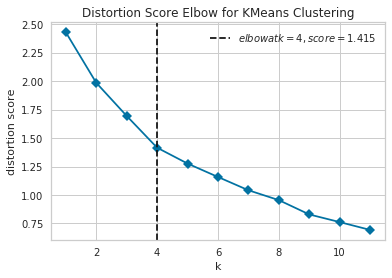

In [237]:
# determine best k using elbow method
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,12), metric='distortion', timings=False, locate_elbow=True
)

visualizer.fit(toronto_grouped_clustering)        
visualizer.poof()   

In [240]:
# set number of clusters
t_kclusters = 4

# run k-means clustering
t_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
t_kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [241]:
toronto_merged_new = toronto_merged
toronto_merged_new["Cluster Labels"] = t_kmeans.labels_

In [242]:
toronto_merged_new

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Trail,Pub,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Indian Restaurant,Grocery Store,Juice Bar,Liquor Store
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Pizza Place,Sandwich Place,Pet Store,Steakhouse,Ice Cream Shop,Italian Restaurant,Food & Drink Shop,Liquor Store,Fast Food Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Bar,Seafood Restaurant,Fish Market,Cheese Shop,Chinese Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Breakfast Spot,Sandwich Place,Dance Studio,Park,Hotel,Gym,Food & Drink Shop,Clothing Store,Filipino Restaurant,Fast Food Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Spa,Restaurant,Rental Car Location,Salon / Barbershop,Chinese Restaurant,Burger Joint,Diner
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Pizza Place,Sandwich Place,Dessert Shop,Gym,Café,Italian Restaurant,Coffee Shop,Sushi Restaurant,Farmers Market,Restaurant
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Playground,Gym,Tennis Court,Restaurant,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
9,M4V,Central Toronto,"South Hill, Rathnelly, Summerhill West, Deer P...",43.686412,-79.400049,1,Pub,Coffee Shop,Sushi Restaurant,Pizza Place,Restaurant,Supermarket,Bagel Shop,Sports Bar,Fried Chicken Joint,Health & Beauty Service


In [243]:
# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(t_kclusters)
ys = [i + x + (i*x)**2 for i in range(t_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_new['Latitude'], toronto_merged_new['Longitude'], toronto_merged_new['Neighborhood'], toronto_merged_new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Toronto Cluster 0** consists of a single neighborhood with health and beauty services.

In [244]:
toronto_merged_new.loc[toronto_merged_new['Cluster Labels'] == 0, toronto_merged_new.columns[[2] + list(range(5, toronto_merged_new.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,0,Health & Beauty Service,Ice Cream Shop,Garden,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


**Toronto Cluster 1** contains most neighborhoods of Toronto proper and seems to contain mostly cafes and restaurants.

In [245]:
toronto_merged_new.loc[toronto_merged_new['Cluster Labels'] == 1, toronto_merged_new.columns[[2] + list(range(5, toronto_merged_new.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,1,Health Food Store,Trail,Pub,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,"The Danforth West, Riverdale",1,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Indian Restaurant,Grocery Store,Juice Bar,Liquor Store
2,"The Beaches West, India Bazaar",1,Park,Pizza Place,Sandwich Place,Pet Store,Steakhouse,Ice Cream Shop,Italian Restaurant,Food & Drink Shop,Liquor Store,Fast Food Restaurant
3,Studio District,1,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Bar,Seafood Restaurant,Fish Market,Cheese Shop,Chinese Restaurant
4,Lawrence Park,1,Park,Bus Line,Yoga Studio,Dumpling Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
5,Davisville North,1,Breakfast Spot,Sandwich Place,Dance Studio,Park,Hotel,Gym,Food & Drink Shop,Clothing Store,Filipino Restaurant,Fast Food Restaurant
6,North Toronto West,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Spa,Restaurant,Rental Car Location,Salon / Barbershop,Chinese Restaurant,Burger Joint,Diner
7,Davisville,1,Pizza Place,Sandwich Place,Dessert Shop,Gym,Café,Italian Restaurant,Coffee Shop,Sushi Restaurant,Farmers Market,Restaurant
8,"Moore Park, Summerhill East",1,Playground,Gym,Tennis Court,Restaurant,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
9,"South Hill, Rathnelly, Summerhill West, Deer P...",1,Pub,Coffee Shop,Sushi Restaurant,Pizza Place,Restaurant,Supermarket,Bagel Shop,Sports Bar,Fried Chicken Joint,Health & Beauty Service


**Toronto Cluster 2** also contains coffee shops but also hotels

In [246]:
toronto_merged_new.loc[toronto_merged_new['Cluster Labels'] == 2, toronto_merged_new.columns[[2] + list(range(5, toronto_merged_new.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Cabbagetown, St. James Town",2,Coffee Shop,Café,Bakery,Pizza Place,Pub,Italian Restaurant,Restaurant,Grocery Store,Snack Place,Jewelry Store
15,St. James Town,2,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Cocktail Bar,Bakery,Cosmetics Shop,Clothing Store,Breakfast Spot
21,"Commerce Court, Victoria Hotel",2,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Deli / Bodega,Steakhouse,Gastropub,Italian Restaurant,Seafood Restaurant


**Toronto Cluster 3** contains a single neighborhood that has some bars and cafes/coffee shops.

In [247]:
toronto_merged_new.loc[toronto_merged_new['Cluster Labels'] == 3, toronto_merged_new.columns[[2] + list(range(5, toronto_merged_new.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Berczy Park,3,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Café,Italian Restaurant,Cheese Shop,Farmers Market,Beer Bar,Steakhouse


## Discussion <a name="discussion"></a>

Through our analysis using Foursquare API data and by only looking at venue types that are common between Manhattan and Toronto proper, it can be concluded that Toronto is not very similar to Manhattan. In particular, Manhattan neighborhoods seem to be defined by the type of food available in them while Toronto neighborhoods seem to be far less so.
To answer the original question, can we recommend a neighborhood of Toronto that is similar to a neighborhood of Manhattan, the answer appears to be no.
However, there are a few ways we could improve our analysis and make a better recommendation.
We could lump categories of food, drinking establishments and the like into one category.
We could also look at actually density of venues versus which are relatively more common.
We could also narrow the types of venues looking only at restaurants, for example.
Since, the initial question asked only how similar in general the neighborhoods are, the analysis suffices.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to determine similar neighborhoods in Manhattan and Toronto Proper. In order to give recommendations to people and companies moving between the two neighborhoods. We have come to the conclusion that the neighborhoods of these two cities are in fact not very similar.
As an extension to this project, it would be a good exercise to look at other large cities and see how well they compare to Manhattan and Toronto. Perhaps London or Paris would make a more suitable match to Manhattan.